In [1]:
# need to run this twice due to bug in imported package

import pandas as pd

import numpy as np
import seaborn as sns
import sys
import json
import ast


from matplotlib_venn import venn2

%load_ext autoreload

%autoreload 2

sys.path.append("../")
from protocols import Helpers
from protocols.BuildCatalogue import BuildCatalogue

import piezo

from protocols.Predict import piezo_predict, piezo_predict_cv

import warnings

warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in scalar divide",
)

## Import the source data from CRyPTIC and NICD

All these data tables were extracted from the CRyPTIC tables v2.1.1. To save space, the `MUTATIONS` table has been subsetted down to only include mutations in *mmpL5*, *pepQ*, *Rv0678*, *atpE* and *mmpS5*. CRyPTIC v2.1.1 was created on 20 March 2024.

In [2]:
phenotypes_cryptic = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_CRYPTIC.csv.gz", index_col=0)
phenotypes_cryptic_samples = set(phenotypes_cryptic.index)

phenotypes_nicd = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_NICD.csv.gz", index_col=0)
phenotypes_nicd_samples = set(phenotypes_nicd.index)

mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz', index_col=0)

mutations["GENE_MUT"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)
mutations["IS_SYNONYMOUS"] = mutations["GENE_MUT"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
mutations["FRS"] = mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)

genomes = pd.read_csv("./data/GENOMES.csv.gz", index_col=0)
growth = pd.read_csv("./data/UKMYC_GROWTH_BDQ.csv.gz")

In [3]:
print(f"The CRyPTIC project has {phenotypes_cryptic.index.nunique()} unique isolates with a BDQ DST measurement\n")

phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.METHOD_3.isin(['UKMYC5','UKMYC6'])]

print(f"Subsetting down to only those samples which were innoculated onto an UKMYC plate reduces the number to {phenotypes_cryptic.index.nunique()}.\n")

phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.QUALITY=='HIGH']

print(f"Accepting those where more than one method agree on the MIC leaves {phenotypes_cryptic.index.nunique()} samples.\n")

phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.index.isin(genomes.index)]

print(f"..and of those only {phenotypes_cryptic.index.nunique()} samples also underwent WGS.")

assert phenotypes_cryptic.index.nunique() == len(phenotypes_cryptic.index), 'one or more samples have more than one DST measurement!'

The CRyPTIC project has 21178 unique isolates with a BDQ DST measurement

Subsetting down to only those samples which were innoculated onto an UKMYC plate reduces the number to 21057.

Accepting those where more than one method agree on the MIC leaves 14605 samples.

..and of those only 10704 samples also underwent WGS.


If we look at the final group of samples which (i) went on an UKMYC plate, (ii) had two or more methods agree on the MIC and (iii) underwent WGS

In [4]:
pd.crosstab(phenotypes_cryptic.METHOD_3, phenotypes_cryptic.PHENOTYPE, margins=True)

PHENOTYPE,R,S,All
METHOD_3,,,
UKMYC5,29,4387,4416
UKMYC6,54,6234,6288
All,83,10621,10704


In [5]:
has_mgit = phenotypes_nicd[phenotypes_nicd.METHOD_CC=='WHO'].index

phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.index.isin(has_mgit)]

print(f"The NICD dataset has {phenotypes_nicd.index.nunique()} unique isolates with a BDQ MGIT960 DST measurement\n")

phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.index.isin(genomes.index)]

print(f".. and of those {phenotypes_nicd.index.nunique()} also underwent WGS ..\n")

print(f".. of these {phenotypes_nicd[(phenotypes_nicd.PHENOTYPE=='R')].index.nunique()} are resistant to BDQ according at least one method\n")

# for samples with more than one DST result this will return the resistant one if they disagree and the MIC if they agree
phenotypes_nicd.reset_index(inplace=True)
phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(Helpers.FilterMultiplePhenos)
phenotypes_nicd.reset_index(drop=True, inplace=True)
phenotypes_nicd.set_index('UNIQUEID',inplace=True)

The NICD dataset has 1168 unique isolates with a BDQ MGIT960 DST measurement

.. and of those 1163 also underwent WGS ..

.. of these 783 are resistant to BDQ according at least one method



Now we can look at how these are split between the DST methods

In [6]:
pd.crosstab(phenotypes_nicd.PHENOTYPE, phenotypes_nicd.METHOD_CC, margins=True)     

METHOD_CC,1.0,WHO,All
PHENOTYPE,,,
R,472,311,783
S,139,241,380
All,611,552,1163


Check that there is no overlap between the two datasets

In [7]:
assert len(phenotypes_nicd_samples.intersection(phenotypes_cryptic_samples)) == 0, "data sets are not mutally exclusive!"

phenotypes = pd.concat([phenotypes_cryptic, phenotypes_nicd]) 

assert phenotypes.index.nunique() == len(phenotypes.index), 'one or more samples have more than one DST measurement!'

print(f"The combined dataset has {len(phenotypes)} samples with a BDQ DST result and WGS data")

The combined dataset has 11867 samples with a BDQ DST result and WGS data


In [8]:
pd.crosstab(phenotypes.PHENOTYPE, phenotypes.METHOD_3, margins=True)

METHOD_3,MGIT960,UKMYC5,UKMYC6,All
PHENOTYPE,,,,
R,783,29,54,866
S,380,4387,6234,11001
All,1163,4416,6288,11867


## Data prep for catalogue building

In [9]:
# Filter out synonymous mutations
cat_mutations = mutations[~mutations["IS_SYNONYMOUS"]].copy()
# cat_mutations.reset_index(inplace=True)

# Merge genomes and phenotypes tables
samples = phenotypes.join(genomes, how="inner")[["DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC"]]

piezo_wildcards = {
    "Rv0678@*=": {"pred": "S", "evid": {}},
    "Rv0678@-*_indel": {"pred": "U", "evid": {}},
    "Rv0678@*_indel": {"pred": "U", "evid": {}},
    "Rv0678@-*?": {"pred": "U", "evid": {}},
    "Rv0678@*?": {"pred": "U", "evid": {}},
    "Rv0678@del_0.0": {"pred": "U", "evid": {}},
    "pepQ@*=": {"pred": "S", "evid": {}},
    "pepQ@-*_indel": {"pred": "U", "evid": {}},
    "pepQ@*_indel": {"pred": "U", "evid": {}},
    "pepQ@-*?": {"pred": "U", "evid": {}},
    "pepQ@*?": {"pred": "U", "evid": {}},
    "pepQ@del_0.0": {"pred": "U", "evid": {}},
    "mmpS5@del_0.0": {"pred": "U", "evid": {}},
    "mmpS5@*=": {"pred": "S", "evid": {}},
    "mmpS5@-*_indel": {"pred": "U", "evid": {}},
    "mmpS5@*_indel": {"pred": "U", "evid": {}},
    "mmpS5@-*?": {"pred": "U", "evid": {}},
    "mmpS5@*?": {"pred": "U", "evid": {}},
    "mmpS5@del_0.0": {"pred": "U", "evid": {}},
    "mmpL5@*=": {"pred": "S", "evid": {}},
    "mmpL5@-*_indel": {"pred": "U", "evid": {}},
    "mmpL5@*_indel": {"pred": "U", "evid": {}},
    "mmpL5@-*?": {"pred": "U", "evid": {}},
    "mmpL5@*?": {"pred": "U", "evid": {}},
    "mmpL5@del_0.0": {"pred": "U", "evid": {}},
    "atpE@*=": {"pred": "S", "evid": {}},
    "atpE@-*_indel": {"pred": "U", "evid": {}},
    "atpE@*_indel": {"pred": "U", "evid": {}},
    "atpE@-*?": {"pred": "U", "evid": {}},
    "atpE@*?": {"pred": "U", "evid": {}},
    "atpE@del_0.0": {"pred": "U", "evid": {}},
}

We use high quality phenotypes due to low signal in CRypTIC 1, and therefore good chance of FP. So get rid of them. 

## Basic Numbers (at FRS 0.75)

### Non-wt samples - used to build catalogues 

In [10]:
all_cat = cat_mutations.join(phenotypes, how='inner')
all_cat.reset_index(inplace=True)
Helpers.CombinedDataTable((all_cat[all_cat.FRS>=0.75]))

All               Minor alleles             All                \
          R      S  Total             R   S Total     R      S  Total   
Total   860  10897  11757            62  57   119  2151  21465  23616   
Rv0678  533    364    897            57  19    76   554    374    928   
mmpL5   859  10895  11754             5  36    41  1572  20638  22210   
pepQ     13    150    163             1   2     3    13    361    374   
mmpS5     1     56     57             0   0     0     1     59     60   
atpE     11     14     25             3   1     4    11     33     44   

       Minor alleles            
                   R   S Total  
Total             67  66   133  
Rv0678            57  19    76  
mmpL5              6  44    50  
pepQ               1   2     3  
mmpS5              0   0     0  
atpE               3   1     4

All 11260 non-wt samples contain an mmpL5 non-synonymous variant - this corresponds to 21481 mutations in mmpL5 in total.

### All samples - used to test catalogues (include wt and synonymous)

In [11]:
all = mutations.join(samples, how='inner')
all['GENE'].fillna('None', inplace=True)
all.reset_index(inplace=True)
Helpers.CombinedDataTable((all[all.FRS>=0.25]))

All               Minor alleles              All                \
          R      S  Total             R    S Total     R      S  Total   
Total   861  10906  11767           239  245   484  2463  22747  25210   
Rv0678  689    431   1120           225   74   299   805    474   1279   
mmpL5   860  10901  11761             7  133   140  1620  21342  22962   
pepQ     20    255    275             8   46    54    22    679    701   
mmpS5     4     79     83             2    2     4     4     83     87   
atpE     12     30     42             3    6     9    12    169    181   

       Minor alleles             
                   R    S Total  
Total            332  441   773  
Rv0678           307   95   402  
mmpL5             10  187   197  
pepQ              10   47    57  
mmpS5              2    2     4  
atpE               3  110   113

## Test the WHO catalogue on our dataset

The WHO have achieved a maximum sensitivity of 59.6% - but this was constructed and validated on a dataset with very limited BDQ resistance. Therefore, let's test on our dataset, which contains new NICD samples... 

Let's now see how this does on the WHOv2 catalogue (incl. epistasis rules)

In [12]:
cm, _cov, _who_sens_75, _who_spec_75, _FN_ids = piezo_predict(all[all.FRS>=0.75], "./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv", "BDQ", Print=False, U_to_S=True)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

df_cm

,R,S
R,430,430
S,141,10759


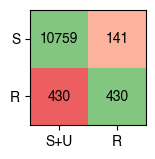

In [13]:
Helpers.plot_truthtables(df_cm, 'foo')

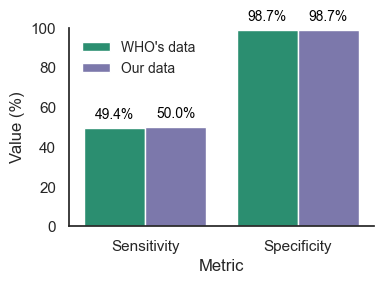

In [14]:
performance = {
    "WHO's data":{"Sensitivity": 49.4, "Specificity": 98.7},
    'Our data':{"Sensitivity": _who_sens_75*100, "Specificity": _who_spec_75*100}
}

Helpers.compare_metrics(performance)

We try at FRS 0.75 first.... then we notice they differentiate between testing at 0.75 and 0.25. So now lets try 0.25....

In [21]:
cm, _cov, _who_sens_25, _who_spec_25, _FN_ids = piezo_predict(all[all.FRS>=0.25], "./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv", "BDQ", Print=False, U_to_S=True)

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

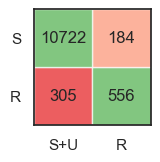

In [22]:
Helpers.plot_truthtables(df_cm, 'foo')

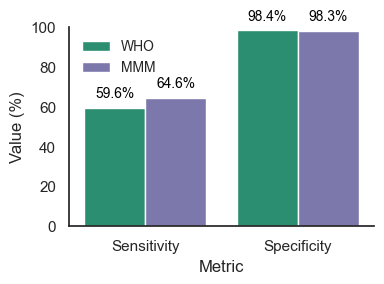

In [28]:
performance = {
    'WHO':{"Sensitivity": 59.6, "Specificity": 98.4},
    'MMM':{"Sensitivity": _who_sens_25*100, "Specificity": _who_spec_25*100}
}

Helpers.compare_metrics(performance)

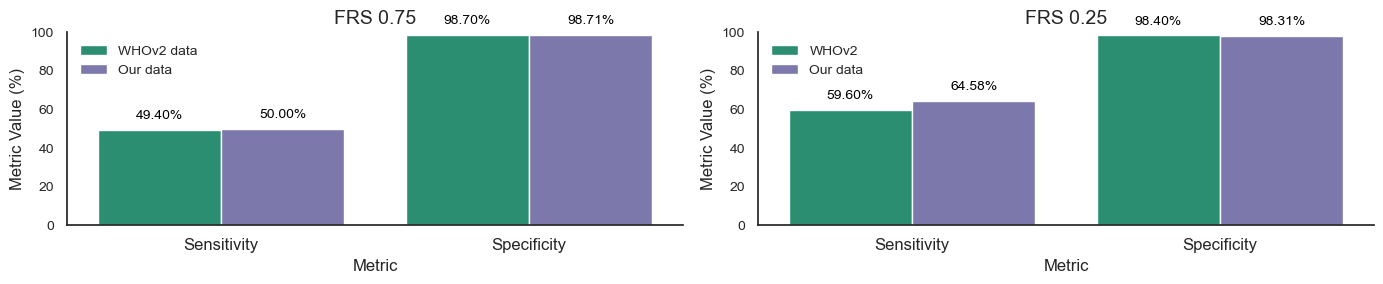

In [13]:
# combine into one axis


performance = {
    0.75: {
        "WHOv2 data": {"Sensitivity": 49.4, "Specificity": 98.7},
        "Our data": {"Sensitivity": _who_sens_75 * 100, "Specificity": _who_spec_75 * 100},
    },
    0.25: {
        "WHOv2": {"Sensitivity": 59.6, "Specificity": 98.4},
        "Our data": {"Sensitivity": _who_sens_25 * 100, "Specificity": _who_spec_25 * 100},
    },
}

Helpers.compare_metrics_2charts(performance)

We don't do too well, although validating at FRS 0.25 does give a big boost

The WHO's approach uses conservative statistical thresholds and a complex, stringent confidence grading system. This can perhaps be justified if one has tonnes of data and a good R population, but that's not relaly the case here. We suspect they're missing variants, which drops their senitivity.

## Build and test our catalogue at FRS 0.75

We have accordingly developed our own algorithm, which is more permissive in its approach, and we construct our catalogues on a dataset injected with novel, highly resistant samples. Owing to mmpL5@I948V being present in every sample, and literature evidence (fowler + whov2) that it is phylogenetic, we assume its neutral. Mirroring the WHO We can construct our catalogue at FRS 0.75 and test at FRS 0.75.

Text(57.08333333333333, 0.5, 'True')

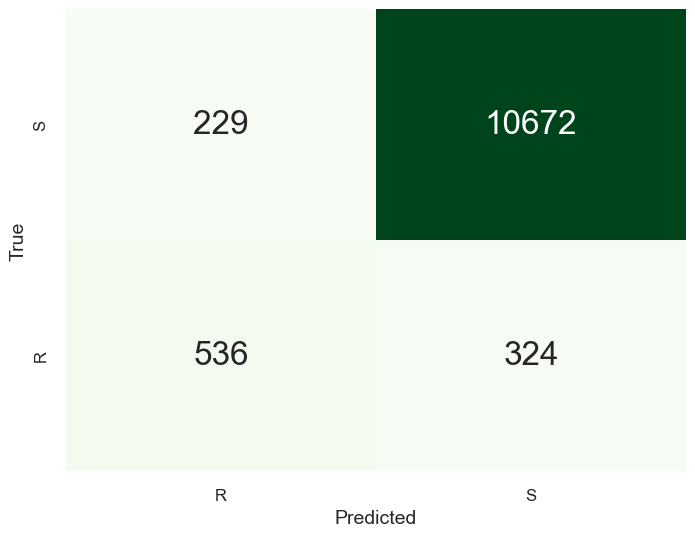

In [14]:
#build at FRS 0.75
catalogue_75 = BuildCatalogue(samples, cat_mutations, 0.75, hardcoded={'mmpL5@I948V': 'S', 'mmpL5@T794I':'S'}).build_piezo(
        "NC_000962.3", f"BDQ-FRS-75-2024.01", "1.1", "BDQ", piezo_wildcards
    ).return_piezo().to_csv(f"./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv", index=False)
#test at FRS 0.75
cm, _cov, _sens_75, _spec_75, _FN_ids = piezo_predict(
        all[all.FRS>=0.75],
        f"./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv",
        "BDQ",
        Print=False,
        U_to_S=True
    )

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(
    df_cm, annot=True, cbar=False, fmt="g", cmap="Greens", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

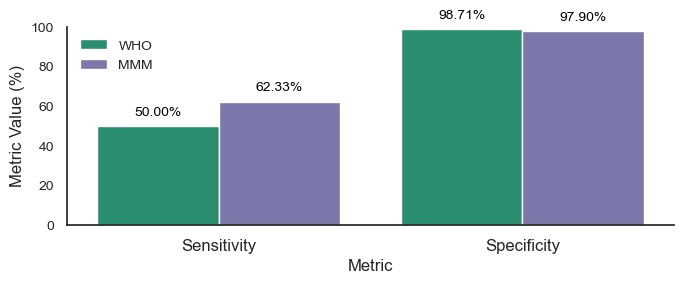

In [15]:
performance = {
    'WHO':{"Sensitivity": _who_sens_75 * 100, "Specificity": _who_spec_75 * 100},
    'MMM':{"Sensitivity": _sens_75*100, "Specificity": _spec_75*100}
}

Helpers.compare_metrics(performance)

We do a bit better than the WHO at a test FRS 0.75. However, they do get an increase at test FRS 0.25, so lets try that.

Text(57.08333333333333, 0.5, 'True')

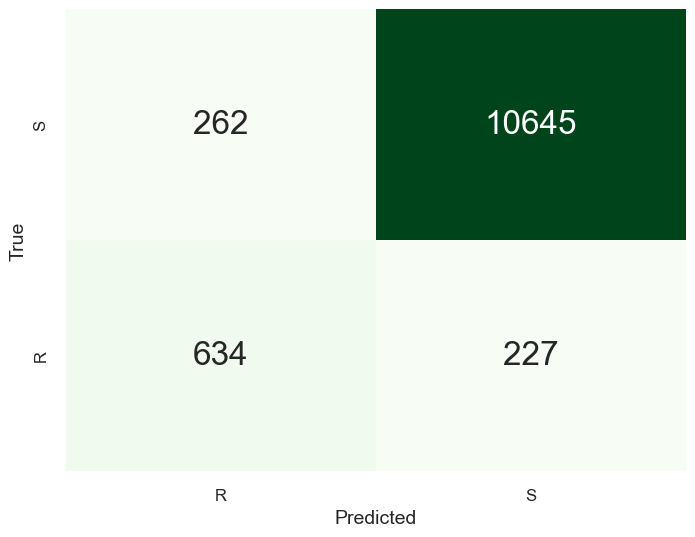

In [16]:
#test at FRS 0.25
cm, _cov, _sens_25, _spec_25, _FN_ids = piezo_predict(
        all[all.FRS>=0.25],
        f"./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv",
        "BDQ",
        Print=False,
        U_to_S=True
    )

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S"])

plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(
    df_cm, annot=True, cbar=False, fmt="g", cmap="Greens", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

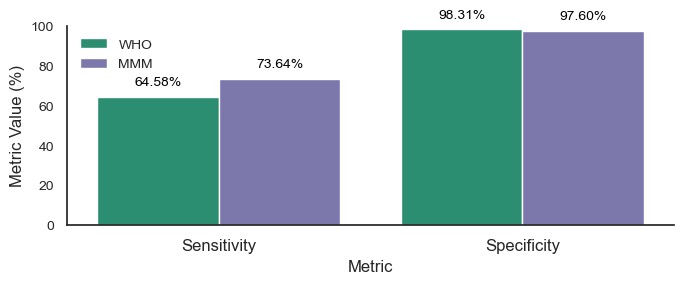

In [17]:
performance = {
    'WHO':{"Sensitivity": _who_sens_25 * 100, "Specificity": _who_spec_25 * 100},
    'MMM':{"Sensitivity": _sens_25*100, "Specificity": _spec_25*100}
}

Helpers.compare_metrics(performance)

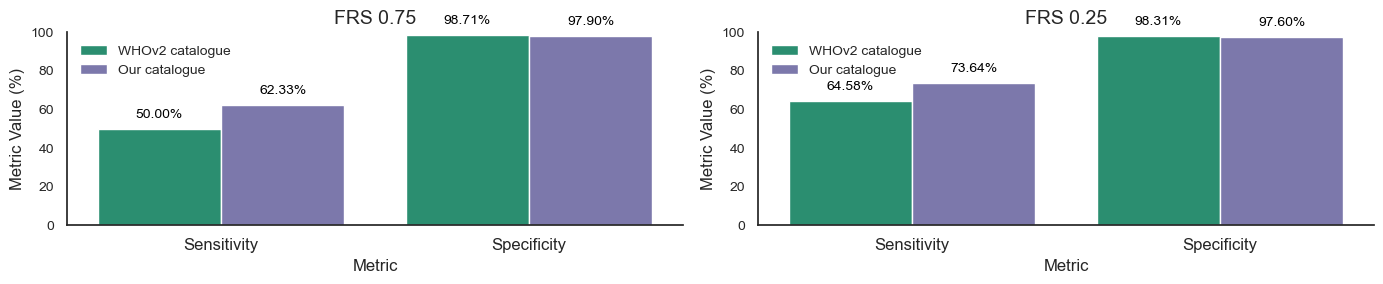

In [18]:
# combine into one axis


performance = {
    0.75: {
        "WHOv2 catalogue": {"Sensitivity": _who_sens_75 * 100, "Specificity": _who_spec_75 * 100},
        "Our catalogue": {"Sensitivity": _sens_75 * 100, "Specificity": _spec_75 * 100},
    },
    0.25: {
        "WHOv2 catalogue": {"Sensitivity": _who_sens_25 * 100, "Specificity": _who_spec_25 * 100},
        "Our catalogue": {"Sensitivity": _sens_25 * 100, "Specificity": _spec_25 * 100},
    },
}

Helpers.compare_metrics_2charts(performance)

## Why do we do better? Discrepancy analysis

In [19]:
who = pd.read_csv('./catalogues/WHOv2/NC_000962.3_WHO-UCN-TB-2023.5_v2.0_GARC1_RFUS.csv')
#U's are basically the same as not catalogued, so can get rid of. 'F's are for HET calls, which have non-HET equivalents, so get rid of
who_bdq = who[(who.DRUG=='BDQ')&(who.PREDICTION.isin(['R', 'S']))]
who_bdq['PREDICTION_VALUES'] = 'RS'


mmm_75 = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv')
mmm_75 = mmm_75[mmm_75.PREDICTION.isin(['R', 'S'])]
#mmpL5 and mmpS5 all come out as susceptible in the WHO catalogues, therefore not much point comparing (and the parsed catalogues don't contain them)
#becuase mmpL5 and mmpS5 are S in both catalogues, we don't need to compare them as they'll come out as S anyway if present/not present (U --> S)
mmm_75 = mmm_75[~mmm_75.index.isin([i for i in mmm_75.index if mmm_75['MUTATION'][i].split('@')[0] in ['mmpL5', 'mmpS5']])]

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_17274/2089491562.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  who_bdq['PREDICTION_VALUES'] = 'RS'


In [20]:
# could use Piezo to determine if mmm mutations exist within the who rules - can natively assess whether our mutations 'match' WHO rules
# e.g) does Rv0678@V1? match Rv0678@V1Q?

# we can use the who catalogue as a catalogue
# we can use the mmm catalogue as the sample df and see what predictions are made for each row. If 'R' or 'S', then there was a match. If 'U' then there was no match (as U's have all been filtered out)
# we also need to add the mmpL5 and mmpS5 genes to the 'catalogue' - we can call their synonymous mutations S as a wildcard as a placeholder (as there shouldnt be any synonymous mutations in the mmm catalogue)
who_comp = who_bdq.append(
    pd.Series(
        [
            "NC_000962.3",
            "WHO-UCN-GTB-PCI-2023.5",
            2.0,
            "GARC1",
            "RS",
            "BDQ",
            "mmpL5@*=",
            "S",
            {},
            {},
            {},
        ],
        index=who_bdq.columns,
    ),
    ignore_index=True,
)
who_comp = who_comp.append(
    pd.Series(
        [
            "NC_000962.3",
            "WHO-UCN-GTB-PCI-2023.5",
            2.0,
            "GARC1",
            "RS",
            "BDQ",
            "mmpS5@*=",
            "S",
            {},
            {},
            {},
        ],
        index=who_comp.columns,
    ),
    ignore_index=True,
)

who_comp.to_csv("./catalogues/temp/who_bdq_adapted.csv")

catalogue = piezo.ResistanceCatalogue("./catalogues/temp/who_bdq_adapted.csv")

matched = {"shared": [], "not_shared": []}
for var in mmm_75.MUTATION:
    try:
        if catalogue.predict(var)["BDQ"] in ["R", "S"]:
            # matched (and either R or S = actually catalogued)
            matched["shared"].append(var)
        else:
            #'U'
            matched["not_shared"].append(var)

    except ValueError:
        matched["not_shared"].append(var)

matched['shared']

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_17274/3040232311.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  who_comp = who_bdq.append(
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_17274/3040232311.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  who_comp = who_comp.append(


['Rv0678@492_ins_g',
 'Rv0678@212_del_c',
 'Rv0678@372_del_g',
 'pepQ@928_ins_g',
 'Rv0678@345_del_g',
 'Rv0678@492_ins_ga',
 'Rv0678@30_del_g',
 'Rv0678@142_ins_t',
 'Rv0678@234_ins_t',
 'pepQ@V1M',
 'Rv0678@c-11a',
 'Rv0678@193_del_g',
 'Rv0678@L117R',
 'Rv0678@192_ins_g',
 'Rv0678@141_ins_c',
 'Rv0678@465_ins_c',
 'atpE@E61D',
 'Rv0678@L32S',
 'Rv0678@Q115!',
 'Rv0678@138_ins_g',
 'Rv0678@136_ins_g',
 'atpE@A63P',
 'pepQ@150_ins_c',
 'Rv0678@Y92!',
 'Rv0678@471_del_cagc',
 'Rv0678@292_del_a',
 'Rv0678@I67S',
 'Rv0678@423_ins_c',
 'Rv0678@M146T',
 'Rv0678@140_ins_tc',
 'Rv0678@199_ins_tc',
 'Rv0678@148_ins_g',
 'Rv0678@289_del_c',
 'Rv0678@287_del_g',
 'Rv0678@150_ins_c',
 'Rv0678@167_del_tggcgacggcgctggcggccagcagcggggggatcagcaccaatgcccggatgctgatccaatttgggttcattgagcggctcgcggtcgccggggatcggcgcacctattt',
 'Rv0678@132_ins_gt',
 'Rv0678@C46R',
 'Rv0678@441_ins_t',
 'Rv0678@G121R',
 'Rv0678@Q76!',
 'Rv0678@265_ins_t',
 'Rv0678@422_ins_tc',
 'Rv0678@N70D',
 'Rv0678@383_del_c',
 'atpE@I66M',

In [21]:
#ok, now determine left and right tails of this (ie not shared)
#to determine which mutations in the WHO catalogue are not present in mmm catalogue, need to remove aggregates (as these could consitute any number of different mutations)
wildcard_chars = {'*', '?', '='}

who_only = who_bdq[~who_bdq['MUTATION'].isin(matched['shared'])]['MUTATION'].unique()
who_only = [i for i in who_only if not any(c in i for c in wildcard_chars)]
who_only

['Rv0678@del_1.0',
 'Rv0678@R38!',
 'Rv0678@R132!',
 'Rv0678@E138!',
 'Rv0678@Y145!',
 'Rv0678@E147!',
 'Rv0678@R156!',
 'atpE@D28G',
 'atpE@D28A',
 'atpE@D28V',
 'pepQ@del_1.0',
 'pepQ@Q5!']

In [22]:
mmm_only = mmm_75[~mmm_75['MUTATION'].isin(matched['shared'])]['MUTATION'].unique()
mmm_only = [i for i in mmm_only if not any(c in i for c in wildcard_chars)]
mmm_only

['pepQ@V238M',
 'Rv0678@R50Q',
 'Rv0678@E55D',
 'Rv0678@G24S',
 'pepQ@A42G',
 'Rv0678@I80M',
 'pepQ@A370V',
 'pepQ@P69L',
 'pepQ@E177D',
 'Rv0678@R156Q',
 'Rv0678@S158R',
 'Rv0678@Q22R',
 'pepQ@R7Q',
 'Rv0678@I108T',
 'Rv0678@Q76E',
 'Rv0678@I80S',
 'Rv0678@Q51K',
 'Rv0678@c-34t',
 'pepQ@F46L',
 'Rv0678@R96G',
 'atpE@T51I',
 'pepQ@P165Q',
 'Rv0678@N4T',
 'pepQ@A263V',
 'pepQ@D20G',
 'pepQ@A153G',
 'Rv0678@I108V',
 'pepQ@T354A',
 'Rv0678@E104G',
 'Rv0678@-21_ins_ttc',
 'Rv0678@D5G',
 'Rv0678@N70K',
 'Rv0678@L74M',
 'atpE@-44_ins_c',
 'pepQ@D26A',
 'pepQ@I24T',
 'Rv0678@402_del_acggctgcggga',
 'Rv0678@V85A',
 'pepQ@K94N',
 'atpE@A45V',
 'Rv0678@T69P',
 'pepQ@S66P',
 'pepQ@S66L',
 'pepQ@V298I',
 'pepQ@G85C',
 'pepQ@N118D',
 'pepQ@V102I',
 'Rv0678@G103S',
 'atpE@A62T',
 'pepQ@D209E',
 'pepQ@V343A',
 'Rv0678@A101E',
 'pepQ@A305V',
 'Rv0678@M17V',
 'pepQ@V101L',
 'Rv0678@c-25t',
 'pepQ@G197R',
 'pepQ@V45L',
 'pepQ@S130L',
 'pepQ@V328F',
 'Rv0678@F27S',
 'Rv0678@L40V',
 'pepQ@G228E',
 'Rv0678

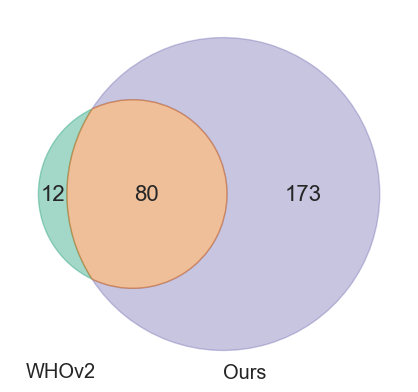

In [23]:
v = venn2(subsets=(len(who_only), len(mmm_only), len(matched['shared'])), set_labels=['WHOv2', 'Ours'])
v.get_patch_by_id('10').set_color('#1b9e77')  # Color for WHO only
v.get_patch_by_id('01').set_color('#7570b3')  # Color for MMM only
v.get_patch_by_id('11').set_color('#d95f02')  # Color for intersection

if v.set_labels[0]:
    label = v.set_labels[0]
    x, y = label.get_position()
    label.set_position((x - 0.13, y-0.215)) 

for text in v.subset_labels:
    if text:
        text.set_fontsize(16)  

plt.show()

In [24]:
# ok, the who catalogue contains 12 mutations ours doesn't and we contain 173 the WHO doesn't.
# but there is an overlap of 80 Rv0678, pepQ, or atpE mutations - lets investigate these and see if there are any phenotype discrepencies

pheno_matched = {'shared':[], 'R_mmm':[], 'S_mmm':[]}

catalogue = piezo.ResistanceCatalogue("./catalogues/temp/who_bdq_adapted.csv")
for mut in mmm_75.index:
    mutation = mmm_75['MUTATION'][mut]
    mmm_predict = mmm_75['PREDICTION'][mut]
    try:
        who_predict = catalogue.predict(mutation)['BDQ']
        if who_predict != 'U':
            if who_predict == mmm_predict:
                # matched (and either R or S = actually catalogued)
                pheno_matched['shared'].append(mutation)
            elif who_predict=='R' and mmm_predict=='S':
                pheno_matched['S_mmm'].append(mutation)
            elif who_predict=='S' and mmm_predict=='R':
                pheno_matched['R_mmm'].append(mutation)

    except ValueError:
            continue

pheno_matched


{'shared': ['pepQ@V1M',
  'Rv0678@193_del_g',
  'Rv0678@L117R',
  'Rv0678@192_ins_g',
  'Rv0678@141_ins_c',
  'Rv0678@465_ins_c',
  'atpE@E61D',
  'Rv0678@L32S',
  'Rv0678@Q115!',
  'Rv0678@138_ins_g',
  'Rv0678@136_ins_g',
  'atpE@A63P',
  'pepQ@150_ins_c',
  'Rv0678@Y92!',
  'Rv0678@471_del_cagc',
  'Rv0678@292_del_a',
  'Rv0678@I67S',
  'Rv0678@423_ins_c',
  'Rv0678@M146T',
  'Rv0678@140_ins_tc',
  'Rv0678@199_ins_tc',
  'Rv0678@148_ins_g',
  'Rv0678@289_del_c',
  'Rv0678@287_del_g',
  'Rv0678@150_ins_c',
  'Rv0678@167_del_tggcgacggcgctggcggccagcagcggggggatcagcaccaatgcccggatgctgatccaatttgggttcattgagcggctcgcggtcgccggggatcggcgcacctattt',
  'Rv0678@132_ins_gt',
  'Rv0678@C46R',
  'Rv0678@441_ins_t',
  'Rv0678@G121R',
  'Rv0678@Q76!',
  'Rv0678@265_ins_t',
  'Rv0678@422_ins_tc',
  'Rv0678@N70D',
  'Rv0678@383_del_c',
  'atpE@I66M',
  'pepQ@817_ins_g',
  'Rv0678@E113!',
  'Rv0678@W42!',
  'Rv0678@137_ins_tg',
  'pepQ@230_ins_g',
  'Rv0678@419_del_g',
  'Rv0678@491_ins_cg',
  'Rv0678@A36V

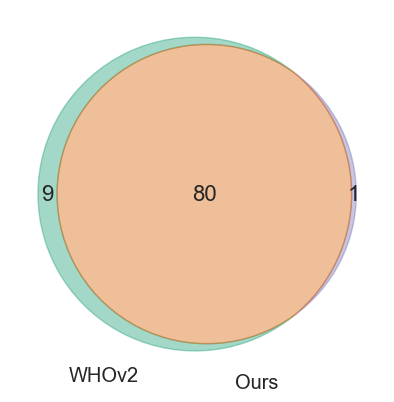

In [25]:
v = venn2(subsets=(len(pheno_matched['S_mmm']), len(pheno_matched['R_mmm']), len(matched['shared'])), set_labels=['WHOv2', 'Ours'])
v.get_patch_by_id('10').set_color('#1b9e77')  # Color for WHO only
v.get_patch_by_id('01').set_color('#7570b3')  # Color for MMM only
v.get_patch_by_id('11').set_color('#d95f02')  # Color for intersection

if v.set_labels[0]:  # Check if the 'WHO' label exists
    label = v.set_labels[0]
    x, y = label.get_position()
    label.set_position((x-0.2 , y)) 
    
    label = v.set_labels[1]
    x, y = label.get_position()
    label.set_position((x+0.1 , y-0.05)) 

for text in v.subset_labels:
    if text:  # Check if the subset label exists
        text.set_fontsize(16)  # Adjust fontsize here


plt.show()

Is the reason we get different performance when testing at FRS 0.25 the same as the WHO? Is it because we are being more liberal? Or is it becuase of our data?

## Build catalogues as a function of FRS

Up until now, we have followed the WHO's strategy of building at FRS 0.75 and testing at 0.75 and 0.25. Surely it makes more sense to also build at FRS 0.25 - if minor alleles are clinically significant and contribute to resistance, then those that exclusively exist at lower FRS should be included in the catalogue surely? If they are relevant, then they should all be captured. We should build at FRS 0.25, however one of the benefifts of a deterministic alogorithmic approach is we can easily construct our catalogues as a function of FRS and compare performance across the entire FRS range. To allow max number of samples in for validation, lets drop out test FRS to 0.1

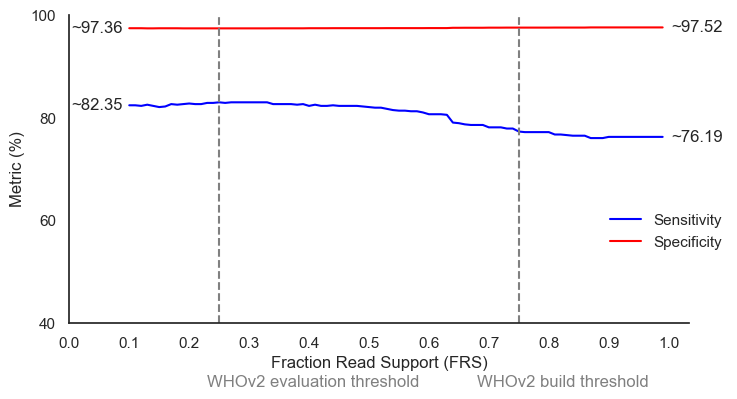

In [28]:
sens, spec, cov, FNs = [], [], [], []
FRS = []
for i in np.arange(0.1, 1, 0.01):
    #Build and save catalogue across FRS range
    BuildCatalogue(samples, cat_mutations, i, hardcoded={'mmpL5@I948V':'S', 'mmpL5@T794I':'S'}).build_piezo(
        "NC_000962.3", f"BDQ-FRS-{i*100}-2024.01", "1.1", "BDQ", piezo_wildcards
    ).return_piezo().to_csv(f"./catalogues/manuscript_2/var_frs/catalogue_FRS_{int(i*100)}.csv", index=False)
    #predict with catalogue at FRS 0.1
    cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all[all.FRS>=0.1],
        f"./catalogues/manuscript_2/var_frs/catalogue_FRS_{int(i*100)}.csv",
        "BDQ",
        Print=False, U_to_S=True
    )
    sens.append(_sens*100)
    spec.append(_spec*100)
    cov.append(_cov*100)
    FNs.append(_FN_ids)
    FRS.append(i)
data = pd.DataFrame(
    {"FRS": FRS, "Sensitivity": sens, "Specificity": spec, "Coverage": cov, "FNs":FNs}
)

Helpers.FRS_vs_metric(data[['FRS', 'Sensitivity', 'Specificity']], cov=False) 

We get a sensitivity drop at lower FRS - . Why? Could either be due to an increase in incorrect classifications (from R to S/U), or from an increase in the number of catalogued mutations with incorrect classifications (increase S/U). A clean way to determine this is a venn diagram of a catalogue built at FRS 0.25 and on at 0.75 (just to be consistent).

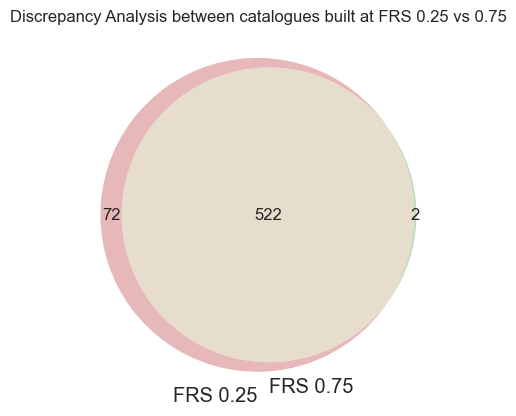

In [29]:
catalogue25 = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_25.csv')
catalogue75 = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_75.csv')

shared = pd.merge(catalogue25, catalogue75, on='MUTATION', how='inner')['MUTATION'].unique()
unique25 = catalogue25[~catalogue25['MUTATION'].isin(shared)]['MUTATION'].unique()
unique75 = catalogue75[~catalogue75['MUTATION'].isin(shared)]['MUTATION'].unique()

venn2(subsets=(len(unique25), len(unique75), len(shared)), set_labels=['FRS 0.25', 'FRS 0.75'])
plt.title("Discrepancy Analysis between catalogues built at FRS 0.25 vs 0.75")
plt.show()

So at FRS 0.25 we have gained 71 mutations (and lost 2).May be easier to examine which classifications changed first - within shared bracket look at discrepencies for S and U.

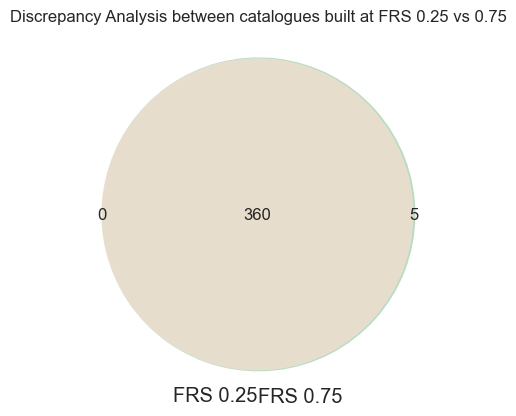

In [30]:
catalogue25_shared =  catalogue25[catalogue25.MUTATION.isin(shared)]
catalogue75_shared =  catalogue75[catalogue75.MUTATION.isin(shared)]

catalogue25_shared_S =  catalogue25_shared[catalogue25_shared.PREDICTION=='S']
catalogue75_shared_S =  catalogue75_shared[catalogue75_shared.PREDICTION=='S']

shared_S = pd.merge(catalogue25_shared_S, catalogue75_shared_S, on='MUTATION', how='inner')['MUTATION'].unique()
unique25_S = catalogue25_shared_S[~catalogue25_shared_S['MUTATION'].isin(shared_S)]['MUTATION'].unique()
unique75_S = catalogue75_shared_S[~catalogue75_shared_S['MUTATION'].isin(shared_S)]['MUTATION'].unique()

venn2(subsets=(len(unique25_S), len(unique75_S), len(shared_S)), set_labels=['FRS 0.25', 'FRS 0.75'])
plt.title("Discrepancy Analysis between catalogues built at FRS 0.25 vs 0.75")
plt.show()

There is no real discordance of shared rows between FRS 0.75 and 0.25.

How many of the 72 incoming mutations are classified as R?

In [35]:
catalogue25[catalogue25.MUTATION.isin(unique25)].PREDICTION.value_counts()

S    37
R    35
Name: PREDICTION, dtype: int64

## All mmpL5 variants are classified as S

Another observation is that all mmpL5 variants are catalouged as S, suggesting mmpL5 does not contribute to resistance. Therefore, we should be able to build a catalogue without the gene with no negative impact on performance:

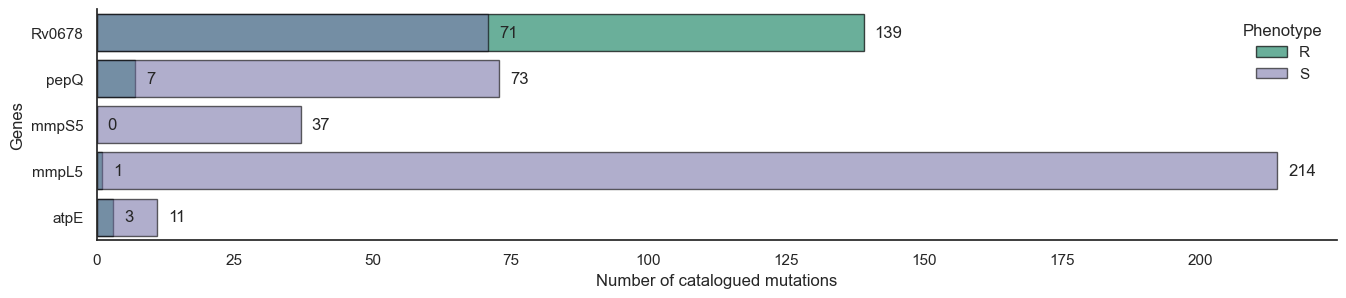

In [37]:
catalogue_01_df = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_10.csv')
catalogue_01_df = catalogue_01_df[~catalogue_01_df['MUTATION'].str.contains('\*', regex=True)]
Helpers.plot_catalogue_counts_h(all, catalogue_01_df)


In [38]:
catalogue_01_df[catalogue_01_df.PREDICTION=='S']

,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@I948V,S,{},{},{}
1,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@T794I,S,{},{},{}
2,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@D767N,S,{},"{""solo_R"": 17, ""solo_S"": 3076, ""background_R"":...",{}
3,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,pepQ@V238M,S,{},"{""solo_R"": 0, ""solo_S"": 1, ""background_R"": 117...",{}
4,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@A147T,S,{},"{""solo_R"": 0, ""solo_S"": 15, ""background_R"": 11...",{}
...,...,...,...,...,...,...,...,...,...,...,...
401,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpS5@A19D,S,{},"{""solo_R"": 0, ""solo_S"": 1, ""background_R"": 135...",{}
402,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@V149I,S,{},"{""solo_R"": 0, ""solo_S"": 1, ""background_R"": 135...",{}
403,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@G336S,S,{},"{""solo_R"": 0, ""solo_S"": 1, ""background_R"": 135...",{}
404,NC_000962.3,BDQ-FRS-10.0-2024.01,1.1,GARC1,RUS,BDQ,pepQ@V1M,S,{},"{""solo_R"": 0, ""solo_S"": 1, ""background_R"": 135...",{}


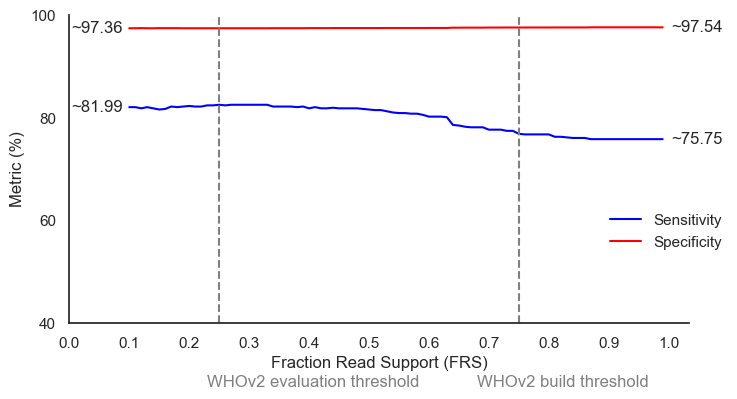

In [39]:
#remove mmpL5 from validation set
all_WT_mmpL5 = pd.merge(samples, mutations[mutations.GENE!='mmpL5'], how='left', on='UNIQUEID')
#remove mmpL5 from mutations df for catalogue building
mutations_no_mmpL5 = cat_mutations[~cat_mutations.GENE.isin(['mmpL5'])]

sens, spec, cov, FNs = [], [], [], []
FRS = []
for i in np.arange(0.1, 1, 0.01):
    #Build and save catalogue
    BuildCatalogue(samples, mutations_no_mmpL5, i).build_piezo(
        "NC_000962.3", f"BDQ-FRS-{i*100}-2024.01", "1.1", "BDQ", piezo_wildcards
    ).return_piezo().to_csv(f"./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_{int(i*100)}.csv", index=False)
    #predict with catalogue
    cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all_WT_mmpL5,
        f"./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_{int(i*100)}.csv",
        "BDQ",
        Print=False, U_to_S=True
    )
    sens.append(_sens*100)
    spec.append(_spec*100)
    cov.append(_cov*100)
    FNs.append(_FN_ids)
    FRS.append(i)



data = pd.DataFrame(
    {"FRS": FRS, "Sensitivity": sens, "Specificity": spec, "Coverage": cov, "FNs":FNs}
)
Helpers.FRS_vs_metric(data[['FRS', 'Sensitivity', 'Specificity']], cov=False) 


Okay, now we get a an increase in sensitivity as FRS drops - and not switch like either, but rather gradual - suggests being more permissive and allowing in Rv0678 minor alleles improves performance - reinforces idea that minor allelels are clinically significant. Let's do a quick discrepency analysis to see why performance increases. Its either because of additional classifications or reclassifications from U/S to R.

In [40]:
#remove mmpL5 from validation set
all_WT_mmpL5 = pd.merge(samples, mutations[mutations.GENE!='mmpL5'], how='left', on='UNIQUEID')
#remove mmpL5 from mutations df for catalogue building
mutations_no_mmpL5 = cat_mutations[~cat_mutations.GENE.isin(['mmpL5'])]
cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all_WT_mmpL5,
        f"./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_{25}.csv",
        "BDQ",
        Print=False, U_to_S=True
    )

In [41]:
_sens

0.8233256351039261

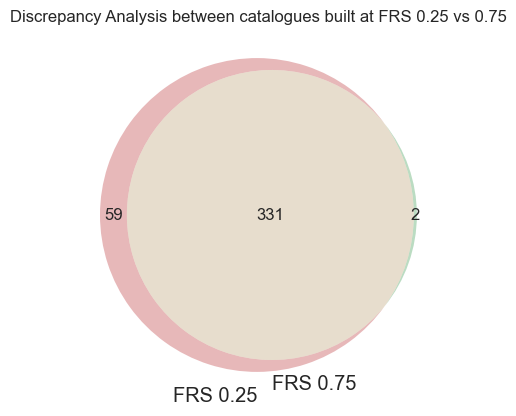

In [42]:
catalogue25 = pd.read_csv('./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_25.csv')
catalogue75 = pd.read_csv('./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_75.csv')

shared = pd.merge(catalogue25, catalogue75, on='MUTATION', how='inner')['MUTATION'].unique()
unique25 = catalogue25[~catalogue25['MUTATION'].isin(shared)]['MUTATION'].unique()
unique75 = catalogue75[~catalogue75['MUTATION'].isin(shared)]['MUTATION'].unique()

venn2(subsets=(len(unique25), len(unique75), len(shared)), set_labels=['FRS 0.25', 'FRS 0.75'])
plt.title("Discrepancy Analysis between catalogues built at FRS 0.25 vs 0.75")
plt.show()

How many of the new mutations are classified as R?

In [43]:
catalogue25[catalogue25.MUTATION.isin(unique25)].PREDICTION.value_counts()

R    35
S    24
Name: PREDICTION, dtype: int64

How many false negatives does this increase in sensitivity correspond to?

In [44]:
data['FRS'] = data['FRS'].round(2)
FN75 = data[data.FRS==0.76].FNs.tolist()[0]
len(FN75) - len(data[data.FRS==0.25].FNs.tolist()[0])

50

How many false negatives are resolved by these new, resistant mutations?

In [45]:
new_R = catalogue25[(catalogue25.MUTATION.isin(unique25))&(catalogue25.PREDICTION=='R')]

all[(all.FRS>=0.1)&(all.UNIQUEID.isin(FN75))&(all.GENE_MUT.isin(unique25))].UNIQUEID.nunique()

34

So 46/51 false negatives that are resolved can be explained by an influx of newly catalogued mutations when the FRS is dropped. There are therefore 5 false negatives that result from a mutation reclassification of U/S to R - lets investigate how many reclassifications of U cause this.

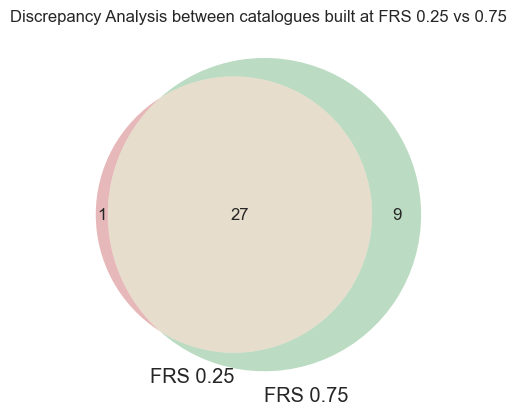

In [46]:
catalogue25_shared =  catalogue25[catalogue25.MUTATION.isin(shared)]
catalogue75_shared =  catalogue75[catalogue75.MUTATION.isin(shared)]

catalogue25_shared_S =  catalogue25_shared[catalogue25_shared.PREDICTION=='U']
catalogue75_shared_S =  catalogue75_shared[catalogue75_shared.PREDICTION=='U']

shared_S = pd.merge(catalogue25_shared_S, catalogue75_shared_S, on='MUTATION', how='inner')['MUTATION'].unique()
unique25_S = catalogue25_shared_S[~catalogue25_shared_S['MUTATION'].isin(shared_S)]['MUTATION'].unique()
unique75_S = catalogue75_shared_S[~catalogue75_shared_S['MUTATION'].isin(shared_S)]['MUTATION'].unique()

venn2(subsets=(len(unique25_S), len(unique75_S), len(shared_S)), set_labels=['FRS 0.25', 'FRS 0.75'])
plt.title("Discrepancy Analysis between catalogues built at FRS 0.25 vs 0.75")
plt.show()

The are 9 mutations catalogued as 'U' at higher FRS whose classification changes when dropping the FRS. How many removed FN samples does this account for?

In [47]:
FN_diff = list(set(FN75).symmetric_difference(set(FN25)))
all[(all.FRS>=0.1)&(all.UNIQUEID.isin(FN_diff))&(all.GENE_MUT.isin(unique75_S))].UNIQUEID.nunique()

14

And how many mutations are actually responsible for this?

In [48]:
all[(all.FRS>=0.1)&(all.UNIQUEID.isin(FN_diff))&(all.GENE_MUT.isin(unique75_S))].GENE_MUT.nunique()

9

Therefore 6 false negative samples whose predicted phenotype change from S to R at lower FRS can be explained by 5 out of 9 mutations which are reclassified from U to R (some redundancy as some of these mutations co-existed with other resistant mutations anyway).

How many reclassifications of S mutations potentially contribute to the loss of FNs?

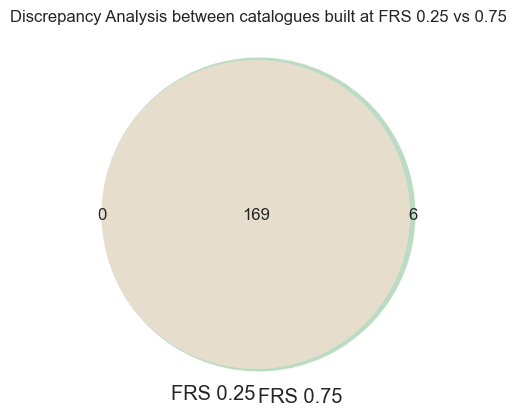

In [49]:
catalogue25_shared_S =  catalogue25_shared[catalogue25_shared.PREDICTION=='S']
catalogue75_shared_S =  catalogue75_shared[catalogue75_shared.PREDICTION=='S']

shared_S = pd.merge(catalogue25_shared_S, catalogue75_shared_S, on='MUTATION', how='inner')['MUTATION'].unique()
unique25_S = catalogue25_shared_S[~catalogue25_shared_S['MUTATION'].isin(shared_S)]['MUTATION'].unique()
unique75_S = catalogue75_shared_S[~catalogue75_shared_S['MUTATION'].isin(shared_S)]['MUTATION'].unique()

venn2(subsets=(len(unique25_S), len(unique75_S), len(shared_S)), set_labels=['FRS 0.25', 'FRS 0.75'])
plt.title("Discrepancy Analysis between catalogues built at FRS 0.25 vs 0.75")
plt.show()

How many FN (which are resolved at low FRS) contain these 2 S mutations at high FRS?

In [50]:
FN_diff = list(set(FN75).symmetric_difference(set(FN25)))
all[(all.FRS>=0.1)&(all.UNIQUEID.isin(FN_diff))&(all.GENE_MUT.isin(unique75_S))].UNIQUEID.nunique()

5

Therefore, 46/51 FN samples at high FRS are correclty predicted R at low FRS due to an influx of new mutations (minor alleles) that are clinically significant and explain resistance. The rest can be explained by reclassiifcations: 2 S --> R + 5 R --> S

## Our optimal catalogue

This is all great, but we should present a catalogue that we can confident in and has attributes we consider more suitable for clinical use.

Attributes:
- No mmpL5 (perhaps include an epistatic link wildcard)
- FRS 0.1 to capture all variants, assuming minor alleles are clinically significant
- Keep U predictions seperate and use a new metric - coverage
- Piezo compatible - standardised format for easy, reproducible parsing
- Contigency table included in 'evidence column'
- All data published with a reproducible pipeline

Limitations:
- Validated on the training set - poor, but we don't have enough data to split

[[  710   135    21]
 [  291 10682    29]]
Catalogue coverage of isolates: 0.9957869902258173
Sensitivity: 0.8402366863905325
Specificity: 0.9734803608858106
0.8402366863905325


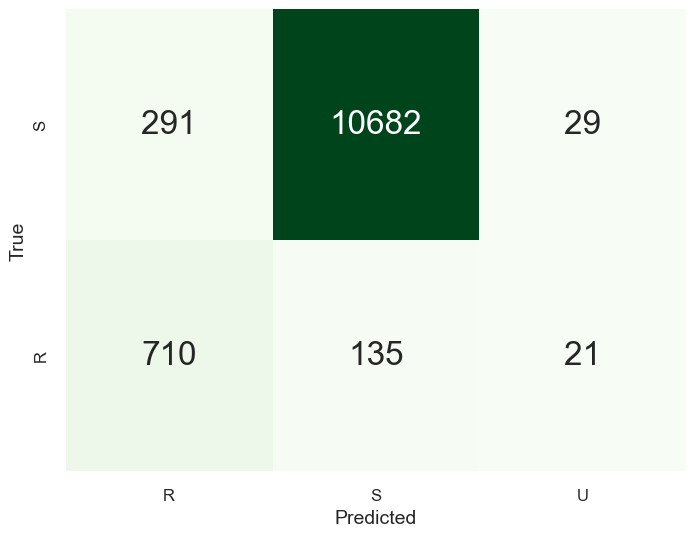

In [ ]:
#remove mmpL5 from validation set
all_WT_mmpL5 = pd.merge(samples, mutations[mutations.GENE!='mmpL5'], how='left', on='UNIQUEID')
#remove mmpL5 from mutations df for catalogue building
mutations_no_mmpL5 = cat_mutations[~cat_mutations.GENE.isin(['mmpL5'])]


#Build and save catalogue
BuildCatalogue(samples, mutations_no_mmpL5, 0.1).build_piezo(
        "NC_000962.3", f"BDQ-FRS-10-2024.01", "1.1", "BDQ", piezo_wildcards
    ).return_piezo().to_csv(f"./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv", index=False)
    #predict with catalogue
cm, _cov, _sens, _spec, _FN_ids = piezo_predict(
        all_WT_mmpL5,
        f"./catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv",
        "BDQ",
        Print=True, U_to_S=False
    )

df_cm = pd.DataFrame(cm, index=["R", "S"], columns=["R", "S", "U"])

plt.figure(figsize=(8, 6))
sns.set_context("talk")
sns.heatmap(
    df_cm, annot=True, cbar=False, fmt="g", cmap="Greens", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)

print (_sens, )

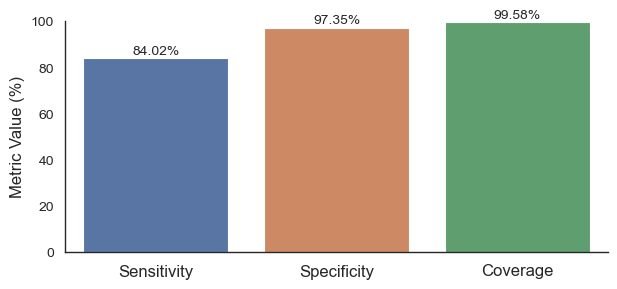

In [ ]:
performance = {
    "Sensitivity": _sens*100, "Specificity": _spec*100, "Coverage": _cov*100
}

Helpers.plot_metrics(performance)

### CV on our optimal catalogue

[[ 140   27   26]
 [  63 2076   42]]
Catalogue coverage of isolates: 0.9713563605728728
Sensitivity: 0.8383233532934131
Specificity: 0.97054698457223
[[ 119   37   16]
 [  59 2112   31]]
Catalogue coverage of isolates: 0.9802021903959562
Sensitivity: 0.7628205128205128
Specificity: 0.9728235836020267
[[ 141   20   23]
 [  53 2101   36]]
Catalogue coverage of isolates: 0.9751474304970514
Sensitivity: 0.8757763975155279
Specificity: 0.9753946146703807
[[ 125   31   20]
 [  39 2113   46]]
Catalogue coverage of isolates: 0.9721988205560236
Sensitivity: 0.8012820512820513
Specificity: 0.9818773234200744
[[ 123   29   17]
 [  60 2107   38]]
Catalogue coverage of isolates: 0.976832350463353
Sensitivity: 0.8092105263157895
Specificity: 0.9723119520073835
isolate_cov (0.9751474304970514, 0.0032079920412232377)
specificity (0.9745908916544191, 0.003960004715103198)
sensitivity (0.817482568245459, 0.03781886456050932)


Text(57.08333333333333, 0.5, 'True')

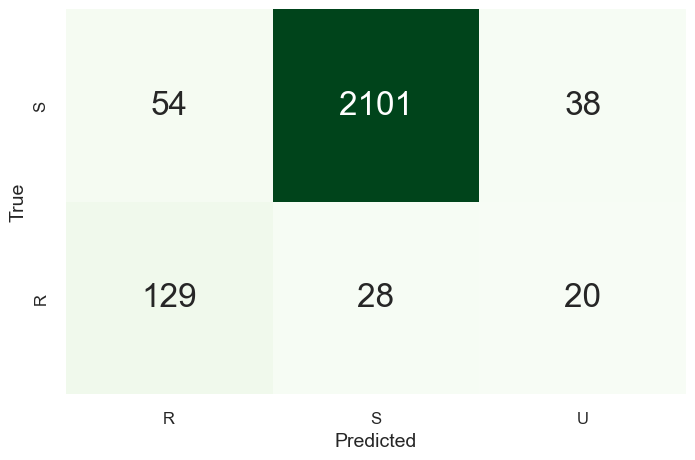

In [ ]:
#remove mmpL5 from validation set
all_WT_mmpL5 = pd.merge(samples, mutations[mutations.GENE!='mmpL5'], how='left', on='UNIQUEID')
#remove mmpL5 from mutations df for catalogue buildingq
mutations_no_mmpL5 = cat_mutations[~cat_mutations.GENE.isin(['mmpL5'])]

df_cm, labels, sens, spec, cov = piezo_predict_cv(all_WT_mmpL5, samples, mutations_no_mmpL5, 0.1, 5, 0.2, 7, "NC_000962.3", f"BDQ-FRS-10-2024.01", "1.1", "BDQ", piezo_wildcards, './catalogues/manuscript_2/cv/')
sns.set_context("talk")
plt.figure(figsize=(8, 5))
sns.heatmap(
    df_cm, annot=labels, cbar=False, cmap="Greens", fmt="", annot_kws={"fontsize": 24}
)
plt.gca().invert_yaxis()



plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)


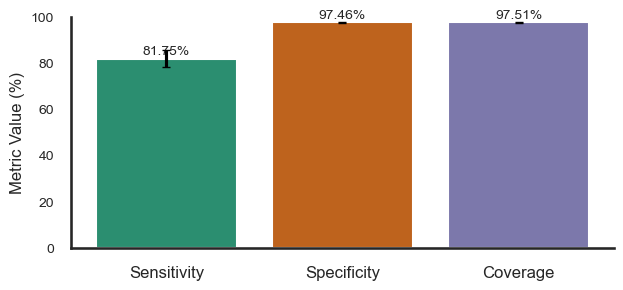

In [ ]:
performance = {
    "Sensitivity": 100*sens[0],
    "Specificity": 100 * spec[0],
    "Coverage": 100 * cov[0],
}
stds = {
    "Sensitivity": 100 * sens[1],
    "Specificity": 100 * spec[1],
    "Coverage": 100 * cov[1],
}

def plot_metrics_std(performance, stds):
    df = pd.DataFrame(performance, index=[0])

    sns.set_style("white")

    plt.figure(figsize=(7, 3))

    # Define your specific colors for the bars here
    colors = ['#1b9e77', '#d95f02', '#7570b3' ]  # Example colors: blue, orange, green

    ax = sns.barplot(data=df, palette=colors)  # Use the palette argument to set the colors

    for k, v in stds.items():

        ax.errorbar(x=k, y=performance[k], yerr=v, color="black", zorder=10, capsize=3)


    ax.set_ylabel("Metric Value (%)", fontsize=12)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=10)

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}%",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 5),
            textcoords="offset points",
            fontsize=10,
        )

    ax.set_ylim(0, 100)

    sns.despine()
    plt.show()

plot_metrics_std(performance, stds)

## Is there a correlation between FRS and MIC?

In [ ]:
all["MIC_FLOAT"] = Helpers.mic_to_float(all["METHOD_MIC"].tolist())

catalogue_01_df = pd.read_csv('./catalogues/manuscript_2/var_frs/catalogue_FRS_10.csv')

R_muts = catalogue_01_df[catalogue_01_df.PREDICTION == "R"].MUTATION.tolist()
# should only look at samples with a single R mutation (can have multipled S) that has been catalogued as R
ids, solo_Rs = all.UNIQUEID.unique(), []
for i in ids:
    df = all[all.UNIQUEID == i]
    if len(df[(df.GENE_MUT.isin(R_muts))]) == 1:
        solo_Rs.append(i)

df = pd.DataFrame.from_dict(
    {
        "GENE_MUT": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].GENE_MUT.tolist(),
        "FRS": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].FRS.tolist(),
        "MIC": [
            i
            for i in (
                (
                    all[
                        (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
                    ].MIC_FLOAT
                )
            ).tolist()
        ],
    }
)

print(
    {
        "GENE_MUT": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].GENE_MUT.tolist(),
        "FRS": all[
            (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
        ].FRS.tolist(),
        "MIC": [
            i
            for i in (
                (
                    all[
                        (all.UNIQUEID.isin(solo_Rs)) & (all.GENE_MUT.isin(R_muts))
                    ].MIC_FLOAT
                )
            ).tolist()
        ],
    }
)

df["binned_FRS"] = [str(round(i, 1)) for i in df.FRS.tolist()]
df["binned_MIC"] = [str(i) for i in df.MIC]

df["MIC"] = [str(i) for i in df.MIC]

{'GENE_MUT': ['Rv0678@c-11a', 'Rv0678@R50Q', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@193_del_g', 'Rv0678@193_del_g', 'Rv0678@193_del_g', 'Rv0678@193_del_g', 'Rv0678@G121R', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@c-11a', 'Rv0678@141_ins_c', 'Rv0678@138_ins_g', 'Rv0678@R38!', 'Rv0678@192_ins_g', 'Rv0678@141_ins_c', 'Rv0678@465_ins_c', 'atpE@E61D', 'Rv0678@192_ins_g', 'Rv0678@132_ins_gt', 'Rv0678@141_ins_c', 'Rv0678@L32S', 'Rv0678@c-11a', 'Rv0678@Q115!', 'Rv0678@193_del_g', 'Rv0678@138_ins_g', 'Rv0678@192_ins_g', 'Rv0678@192_ins_g', 'Rv0678@138_ins_g', 'Rv0678@141_ins_c', 'Rv0678@M146T', 'Rv0678@R94W', 'Rv0678@138_ins_g', 'Rv0678@138_ins_g', 'pepQ@298_ins_c', 'Rv0678@141_ins_c', 'atpE@A63P

/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_10273/3927752375.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(
/var/folders/s5/pshvb2093574r5hqnwcy6klw0000gn/T/ipykernel_10273/3927752375.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(


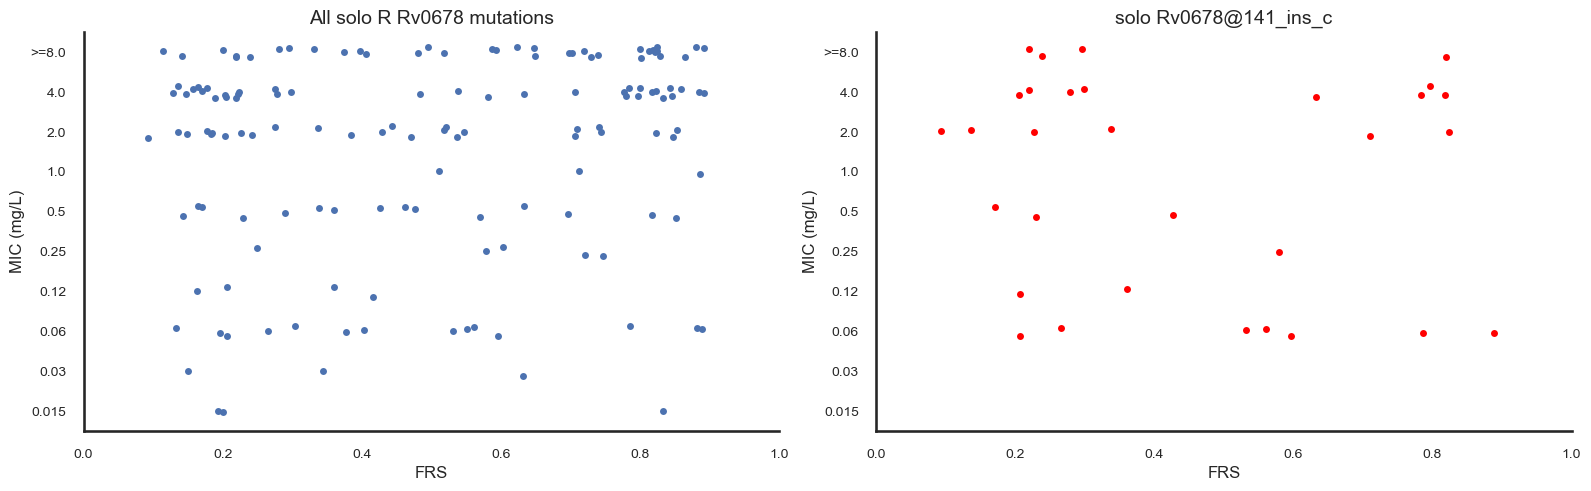

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

sns.set_context("paper")

# axes[0].set_ylim(0, 3.5)
y_axis_order = [
    "0.015",
    "0.03",
    "0.06",
    "0.12",
    "0.25",
    "0.5",
    "1.0",
    "2.0",
    "4.0",
    "8.0",
]

sns.stripplot(
    x="FRS", y="MIC", data=df[df.FRS < 0.9], ax=axes[0], jitter=0.15, order=y_axis_order
)
axes[0].set_title("All solo R Rv0678 mutations", fontsize=14)
axes[0].invert_yaxis()
axes[0].set_yticklabels(
    ["0.015", "0.03", "0.06", "0.12", "0.25", "0.5", "1.0", "2.0", "4.0", ">=8.0"]
)
axes[0].set_xlabel("FRS", fontsize=12)
axes[0].set_ylabel("MIC (mg/L)", fontsize=12)
axes[0].tick_params(axis="both", labelsize=10)


axes[0].set_xlim(0, 1)

sns.stripplot(
    x="FRS",
    y="MIC",
    data=df[(df.GENE_MUT == "Rv0678@141_ins_c") & (df.FRS < 0.9)],
    ax=axes[1],
    jitter=0.15,
    color="red",
    order=y_axis_order,
)
axes[1].set_title("solo Rv0678@141_ins_c", fontsize=14)
axes[1].invert_yaxis()
axes[1].set_yticklabels(
    ["0.015", "0.03", "0.06", "0.12", "0.25", "0.5", "1.0", "2.0", "4.0", ">=8.0"]
)

axes[1].set_xlim(0, 1)
# axes[1].set_ylim(0, 3.5)
axes[1].set_xlabel("FRS", fontsize=12)
axes[1].set_ylabel("MIC (mg/L)", fontsize=12)
axes[1].tick_params(axis="both", labelsize=10)


# Adjust layout
plt.tight_layout()
sns.despine()

# Show the plot
plt.show()

There is no correlation between FRS and MIC for Rv0678 resistant variants generally, as well as for the most variable (wrt FRS) mutations in Rv0678. This would suggest there is no effective fitness cost resulting from Rv0678 resistant mutations, as minor resistant populations can rapidly outcompete major WT populations. It would be interesting to analyse growth data from the plates, however this data is not available.

## Is there a correlation between FRS and Growth?

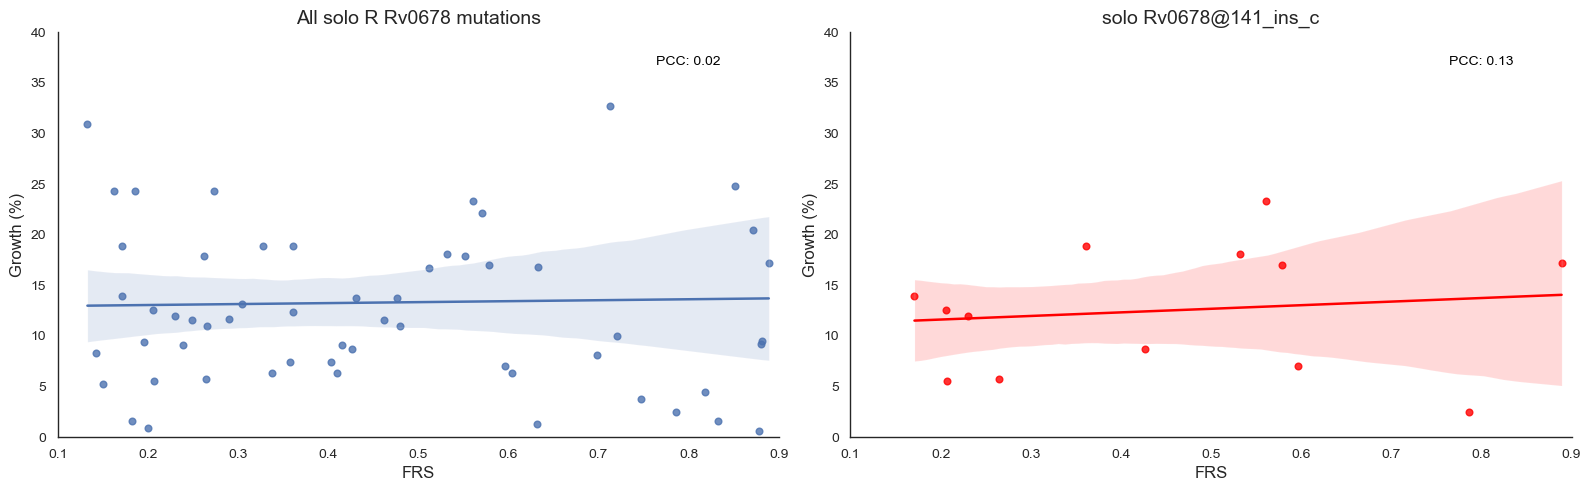

In [ ]:
growth_dil = growth[(growth.DILUTION.isin([1, 2, 3])) & (growth.READINGDAY == 14)]
# subset growth data to dilutions of 1, 2, or 3 fold so there is drug present, and only look at growth at 14 days post incubation
growth_dil = growth_dil[["UNIQUEID", "GROWTH"]].groupby("UNIQUEID").mean()
# average growth across dilutions

df = pd.merge(growth_dil, cat_mutations[cat_mutations.GENE=='Rv0678'], how='inner', on='UNIQUEID')
#filter for samples with only a single resistant mutation (and however many S)
df = df[df.UNIQUEID.isin(solo_Rs)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

sns.regplot(x="FRS", y="GROWTH", data=df[df.FRS < 0.9], ax=axes[0], ci=95)
axes[0].set_title("All solo R Rv0678 mutations", fontsize=14)
axes[0].set_xlim(0.1, 0.9)
axes[0].set_ylim(0, 40)

axes[0].set_xlabel("FRS", fontsize=12)
axes[0].set_ylabel("Growth (%)", fontsize=12)
axes[0].tick_params(axis="both", labelsize=10)

# Calculate Pearson correlation coefficient
pcc_value = df[df.FRS < 0.9][["FRS", "GROWTH"]].corr().iloc[0, 1]

# Annotate the first subplot with the PCC value
axes[0].annotate(
    f"PCC: {pcc_value:.2f}",
    xy=(0.83, 0.92),
    xycoords="axes fraction",
    fontsize=10,
    color="black",
)


sns.regplot(
    x="FRS",
    y="GROWTH",
    data=df[(df.GENE_MUT == "Rv0678@141_ins_c") & (df.FRS < 0.9)],
    ax=axes[1],
    color="red",
    ci=95,
)
axes[1].set_title("solo Rv0678@141_ins_c", fontsize=14)
axes[1].set_xlim(0.1, 0.9)  # Set x-axis range
axes[1].set_ylim(0, 40)

axes[1].set_xlabel("FRS", fontsize=12)
axes[1].set_ylabel("Growth (%)", fontsize=12)
axes[1].tick_params(axis="both", labelsize=10)


# Calculate Pearson correlation coefficient
pcc_value = (
    df[(df.FRS < 0.9) & (df.GENE_MUT == "Rv0678@141_ins_c")][["FRS", "GROWTH"]]
    .corr()
    .iloc[0, 1]
)

# Annotate the first subplot with the PCC value
axes[1].annotate(
    f"PCC: {pcc_value:.2f}",
    xy=(0.83, 0.92),
    xycoords="axes fraction",
    fontsize=10,
    color="black",
)
sns.despine()

# Adjust layout
plt.tight_layout()


### Aggregate rules

The WHO have used aggregate rules for all loss of function mutations in Rv0678 and pepQ, solely based off literature evidence. The question is, does the data suggest this approach is valid and should we be doing the same?   

If we can demonstrate sufficient phenotype homogeneity and a strong mean penetration, then an additional aggregate rule could be justified. 

However 4/22 and 70/324 Rv0678 premature stops and frameshifts are susceptible (in the catalogue), which seems quite high if we're going to assume they all have the same effect.

Lets look at odds ratios.

In [ ]:
rules = ["*_fs", "*!"]

catalogue = pd.read_csv("catalogues/manuscript_2/rem_mmpL5/catalogue_FRS_10.csv")

with open("../../tb-cat-builder/wildcards/bdq_wildcards.json", "r") as f:
    wildcards = json.load(f)

aggregate_vars = {}

for rule in rules:
    aggregate_rule = piezo.ResistanceCatalogue(f"./temp/bdq_Rv0678@{rule}.csv")

    for i in catalogue.index:
        mutation = catalogue["MUTATION"][i]

        if (mutation != aggregate_rule) and (mutation not in wildcards.keys()):
            if aggregate_rule.predict(mutation)["BDQ"] == "R":
                evidence = ast.literal_eval(catalogue["EVIDENCE"][i])
                aggregate_vars[mutation] = [
                    evidence["solo_R"],
                    evidence["solo_S"],
                    evidence["background_R"],
                    evidence["background_S"],
                ]

cont_df = {}
for mut, ev in aggregate_vars.items():
    cont_df[mut] = {
        "R": ev[0],
        "S": ev[1],
        "'R": ev[2],
        "'S": ev[3],
        "n_total": ev[0] + ev[1],
    }

contingency_df = pd.DataFrame(cont_df).T
contingency_df["Gene"] = [i.split("@")[0] for i in contingency_df.index]


def extract_position(mutation):
    parts = mutation.split("@")[1]
    position = "".join(filter(str.isdigit, parts.split("_")[0]))
    return int(position)


contingency_df["Position"] = contingency_df.index.map(extract_position)
contingency_df = contingency_df.sort_values(by="Position")

contingency_df

,R,S,'R,'S,n_total,Gene,Position
Rv0678@14_ins_cggggtg,0,1,136,10322,1,Rv0678,14
Rv0678@16_del_g,4,0,136,10683,4,Rv0678,16
Rv0678@30_del_g,0,3,136,10322,3,Rv0678,30
Rv0678@R38!,1,1,136,10683,2,Rv0678,38
Rv0678@W42!,1,0,136,10683,1,Rv0678,42
...,...,...,...,...,...,...,...
Rv0678@466_ins_g,1,0,136,10683,1,Rv0678,466
Rv0678@471_del_cagc,3,0,136,10683,3,Rv0678,471
Rv0678@491_ins_cg,5,1,136,10683,6,Rv0678,491
Rv0678@492_ins_g,0,1,136,10322,1,Rv0678,492


In [ ]:
contingency_df.sort_values(by=['Position'], inplace=True, ascending=False)

In [ ]:
odds_ratios = []
for i in contingency_df.index:
    if np.sum([contingency_df['R'][i], contingency_df['S'][i]]):
        # need to additive continuity correction to avoid any 'zero' cells
        odds_ratios.append(((contingency_df['R'][i]+0.5)*(contingency_df["'S"][i]+0.5))/((contingency_df['S'][i]+0.5)*(contingency_df["'R"][i]+0.5)))

log_odds = np.log(odds_ratios)
contingency_df['OR'] = odds_ratios
contingency_df['log_OR'] = log_odds

In [ ]:
contingency_df['SE'] = np.sqrt(1/(contingency_df['R']+0.5) + 1/(contingency_df['S']+0.5) + 1/(contingency_df["'R"]+0.5) + 1/(contingency_df["'S"]+0.5))
contingency_df['CI_lower'] = np.exp(contingency_df['log_OR'] - 1.96 * contingency_df['SE'])
contingency_df['CI_upper'] = np.exp(contingency_df['log_OR'] + 1.96 * contingency_df['SE'])
contingency_df['log_CI_lower'] = np.log(contingency_df['CI_lower'])
contingency_df['log_CI_upper'] = np.log(contingency_df['CI_upper'])
contingency_df


,R,S,'R,'S,n_total,Gene,Position,OR,log_OR,SE,CI_lower,CI_upper,log_CI_lower,log_CI_upper
Rv0678@492_ins_ga,0,1,136,10322,1,Rv0678,492,25.207570,3.227144,1.635264,1.022271,621.578689,0.022026,6.432263
Rv0678@492_ins_g,0,1,136,10322,1,Rv0678,492,25.207570,3.227144,1.635264,1.022271,621.578689,0.022026,6.432263
Rv0678@491_ins_cg,5,1,136,10683,6,Rv0678,491,286.980464,5.659414,0.925151,46.810994,1759.368460,3.846118,7.472710
Rv0678@471_del_cagc,3,0,136,10683,3,Rv0678,471,547.871795,6.306041,1.514310,28.162584,10658.237418,3.337994,9.274088
Rv0678@466_ins_g,1,0,136,10683,1,Rv0678,466,234.802198,5.458743,1.635263,9.522213,5789.838317,2.253627,8.663860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rv0678@W42!,1,0,136,10683,1,Rv0678,42,234.802198,5.458743,1.635263,9.522213,5789.838317,2.253627,8.663860
Rv0678@R38!,1,1,136,10683,2,Rv0678,38,78.267399,4.360131,1.157909,8.090008,757.203876,2.090630,6.629633
Rv0678@30_del_g,0,3,136,10322,3,Rv0678,30,10.803244,2.379846,1.514311,0.555324,210.165569,-0.588203,5.347896
Rv0678@16_del_g,4,0,136,10683,4,Rv0678,16,704.406593,6.557356,1.493199,37.738720,13147.998803,3.630687,9.484025


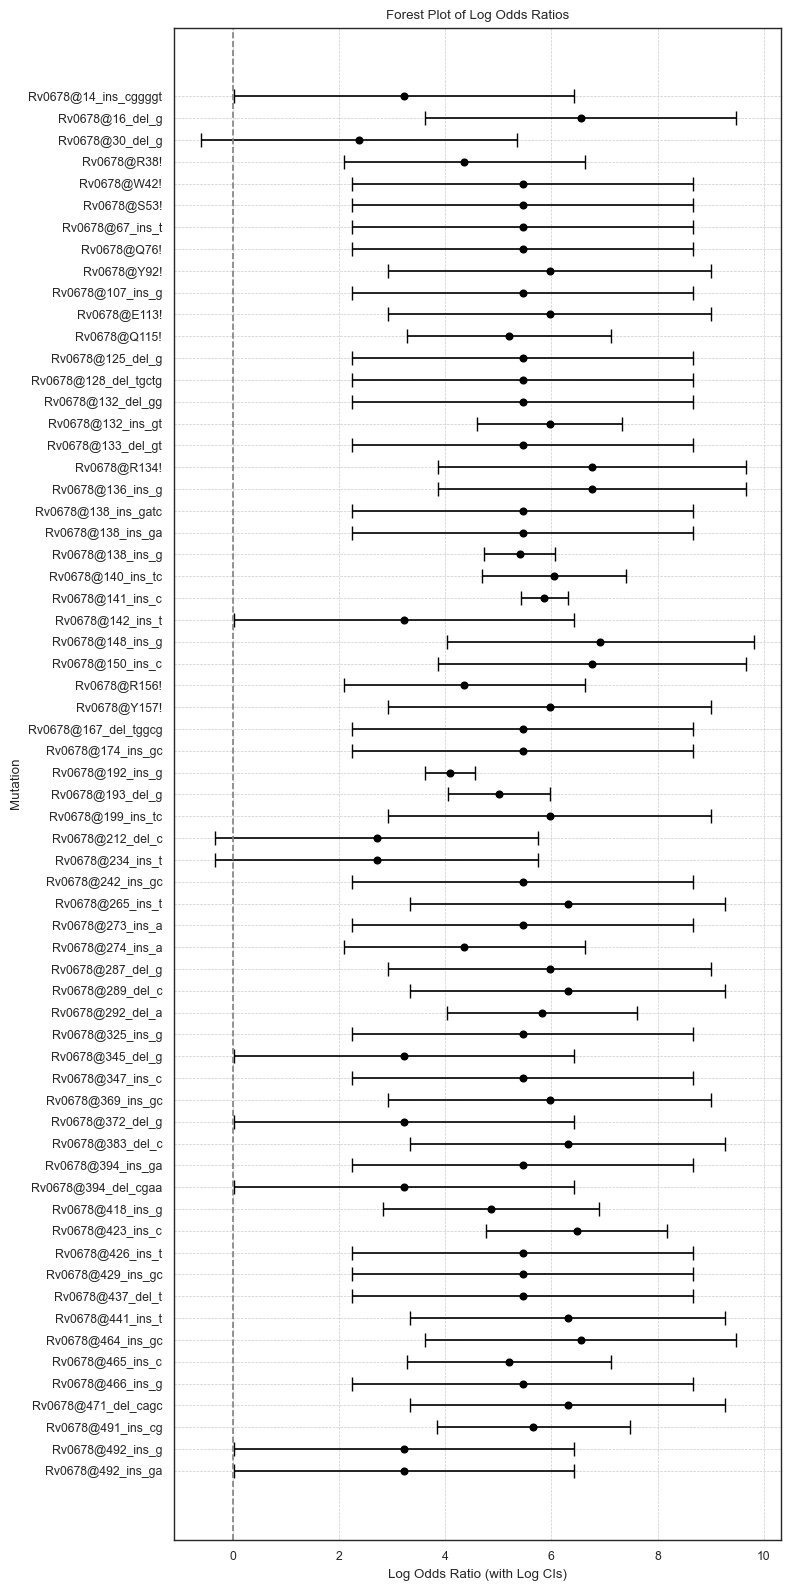

In [ ]:
fig, ax = plt.subplots(figsize=(8, 16))  # Increased height to 10 inches
# The xerr needs to be recalculated as we're now using log values
xerr = [contingency_df['log_OR'] - contingency_df['log_CI_lower'], contingency_df['log_CI_upper'] - contingency_df['log_OR']]
ax.errorbar(x=contingency_df['log_OR'], y=np.arange(len(contingency_df)), xerr=xerr, fmt='o', color='black', capsize=5)
ax.set_yticks(np.arange(len(contingency_df)))
ax.set_yticklabels([i if len(i)< 20 else i[:20] for i in contingency_df.index ])

plt.axvline(x=0, color='grey', linestyle='--')  # Add a line at log OR = 0 (OR = 1) for reference

plt.title('Forest Plot of Log Odds Ratios')
plt.xlabel('Log Odds Ratio (with Log CIs)')
plt.ylabel('Mutation')
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()

# Optionally, customize the x-axis to show OR values instead of log OR for easier interpretation

plt.show()

In [ ]:
catalogue = BuildCatalogue(samples, mutations, 0.1).build_piezo(
        "NC_000962.3", f"BDQ-FRS-10-2024.01", "1.1", "BDQ", piezo_wildcards
    )
catalogue.update({'Rv0678@*_fs':'R'}).build_piezo(
        "NC_000962.3", f"BDQ-FRS-10-2024.01", "1.1", "BDQ", piezo_wildcards
    ).return_piezo()
    #predict with catalogue


,GENBANK_REFERENCE,CATALOGUE_NAME,CATALOGUE_VERSION,CATALOGUE_GRAMMAR,PREDICTION_VALUES,DRUG,MUTATION,PREDICTION,SOURCE,EVIDENCE,OTHER
0,NC_000962.3,BDQ-FRS-10-2024.01,1.1,GARC1,RUS,BDQ,Rv0678@*_fs,R,{},"{""solo_R"": 80, ""solo_S"": 60, ""background_R"": 5...",{}
1,NC_000962.3,BDQ-FRS-10-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@I948V,S,{},"{""solo_R"": 47, ""solo_S"": 4464, ""background_R"":...",{}
2,NC_000962.3,BDQ-FRS-10-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@L510P,S,{},"{""solo_R"": 0, ""solo_S"": 1, ""background_R"": 5, ...",{}
3,NC_000962.3,BDQ-FRS-10-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@P595P,S,{},"{""solo_R"": 0, ""solo_S"": 1, ""background_R"": 5, ...",{}
4,NC_000962.3,BDQ-FRS-10-2024.01,1.1,GARC1,RUS,BDQ,mmpL5@A742A,S,{},"{""solo_R"": 0, ""solo_S"": 1, ""background_R"": 5, ...",{}
...,...,...,...,...,...,...,...,...,...,...,...
372,NC_000962.3,BDQ-FRS-10-2024.01,1.1,GARC1,RUS,BDQ,atpE@-*_indel,U,{},{},{}
373,NC_000962.3,BDQ-FRS-10-2024.01,1.1,GARC1,RUS,BDQ,atpE@*_indel,U,{},{},{}
374,NC_000962.3,BDQ-FRS-10-2024.01,1.1,GARC1,RUS,BDQ,atpE@-*?,U,{},{},{}
375,NC_000962.3,BDQ-FRS-10-2024.01,1.1,GARC1,RUS,BDQ,atpE@*?,U,{},{},{}
